<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
import lasagne.layers as layers
import lasagne.objectives as objectives
import lasagne.nonlinearities as nonlinearities
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers
from bnr_ml.objectdetect.utils import BoundingBox, draw_coord
import bnr_ml.objectdetect.utils as utils

from selectivesearch import selective_search

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 0:
                counts[0] += 1
            elif obj['label'] == 1:
                counts[1] += 1
            elif obj['label'] == 2:
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
def get_num_from_label(obj):
    lab = obj['label'].lower()
    if 'car' == lab:
        obj['label'] = 0
    elif 'bicycle' == lab:
        obj['label'] = 1
    elif 'bike' == lab:
        obj['label'] = 2
    elif 'person' == lab:
        obj['label'] = 3
    else:
        obj['label'] = 4
    return obj

In [6]:
def fix_obj(obj):
    x, y = obj['p1'][0], obj['p1'][1]
    w, h = obj['p2'][0] - x, obj['p2'][1] - y
    obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
    del obj['p1'], obj['p2']
    return get_num_from_label(obj)

In [7]:
add_proper_labels(annotations)

In [8]:
annotations = [[fix_obj(obj) for obj in objs] for objs in annotations]

In [9]:
annotations = np.asarray(annotations)

In [10]:
counts = get_label_counts(annotations)

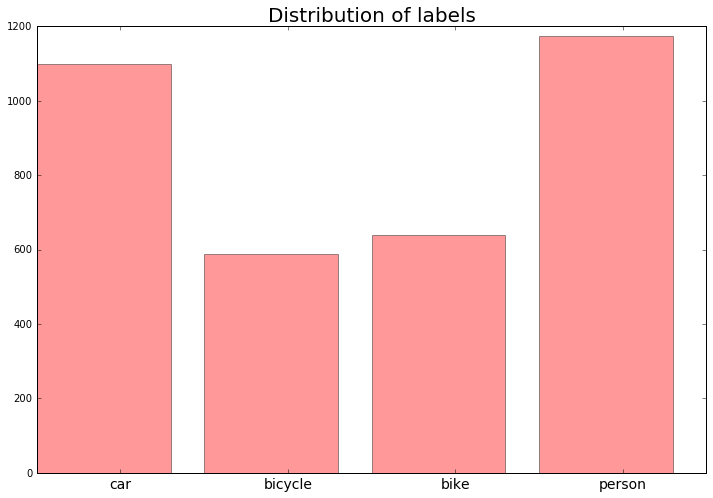

In [11]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [12]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [13]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [14]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [15]:
num_epochs = 1000
batch_size = 50

In [16]:
num_classes = 4

In [17]:
test_net = False
if test_net:
    gen = test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:50], input_shape, num_classes, num_rios=1, per_batch=50)
    X,y = [g for g in gen][0]
    X,y = theano.shared(X), theano.shared(y)
    input_var = X
else:
    input_var = None

In [97]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape, input_var=input_var)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3), nonlinearity=nonlinearities.leaky_rectify)
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1), nonlinearity=nonlinearities.leaky_rectify)


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048, nonlinearity=None)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.7), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [98]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [99]:
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048, nonlinearity=None)
net['detect'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [101]:
load_weights = False
if load_weights:
    with open('fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:-2])
        set_all_param_values(net['localize'], tmp)

<b>Train the network

In [104]:
reload(fastrcnn)
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.py'>

In [105]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

cost = detector._get_cost(detector._detect_test, detector._localize_test, y)

In [106]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [108]:
train_gen = fastrcnn.FastRCNNDetector.generate_data(train_annotations[:100], input_shape, num_classes, num_rios=25, per_batch=2)
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:100], input_shape, num_classes, num_rios=1, per_batch=50)
train_loss, test_loss = detector.train(
    train_gen,
    test_gen,
    print_obj,
    lr=2e-5,
    lmbda=0.,
    epochs=num_epochs
)

Getting cost...
Compiling...
Compiling took 23.434 seconds
Beginning training
Batch error: 1.3577
Batch error: 1.4753
Batch error: 1.3866
Batch error: 1.3480
Batch error: 0.8741
Batch error: 1.2890
Batch error: 0.8204
Batch error: 0.8005
Batch error: 1.1499
Batch error: 1.1194
Batch error: 1.4066
Batch error: 1.0396
Batch error: 1.1297
Batch error: 0.8933
Batch error: 0.6868
Batch error: 0.7881
Batch error: 0.6738
Batch error: 0.8009
Batch error: 1.1134
Batch error: 0.8452
Batch error: 0.8909
Batch error: 0.8512
Batch error: 0.8503
Batch error: 0.7595
Batch error: 0.5537
Batch error: 0.8494
Batch error: 0.6242
Batch error: 0.5494
Batch error: 0.6165
Batch error: 0.5891
Batch error: 0.5501
Batch error: 0.7366
Batch error: 0.6222
Batch error: 0.8215
Batch error: 0.5201
Batch error: 0.3549
Batch error: 0.8446
Batch error: 0.5964
Batch error: 0.4905
Batch error: 0.8801
Batch error: 0.8928
Batch error: 0.7665
Batch error: 1.2679
Batch error: 1.0501
Batch error: 0.5587
Batch error: 1.0585
Ba

In [ ]:
concat_losses = False
if concat_losses:
    train_loss_total, test_loss_total = train_loss, test_loss
else:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')

plt.show()

In [91]:
with open('fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)

In [ ]:
def trans_regions(regions):
    regs = np.zeros((regions.__len__(), 4))
    for i in range(regions.__len__()):
        regs[i] = regions[i]['rect']
    return regs

In [54]:
def num2label(num):
    if num == 0:
        return 'car'
    if num == 1:
        return 'bicycle'
    if num == 2:
        return 'bike'
    if num == 3:
        return 'person'
    else:
        return 'noobj'

In [ ]:
im = imread(test_annotations[232][0]['image'])

In [ ]:
regions = selective_search(im, scale=500, sigma=0.9, min_size=400)

In [ ]:
regions = trans_regions(regions[1])
print regions.shape

In [ ]:
class_score, coord = detector.detect(im, proposals=regions[:50], thresh=.8)
print coord.shape
preds = np.concatenate((coord, np.max(class_score, axis=1, keepdims=True), \
                        np.argmax(class_score, axis=1).reshape((-1,1))), axis=1)

In [ ]:
print coord

In [ ]:
reload(utils)

In [ ]:
im_draw = utils.draw_coord(im, preds[:], label_map=num2label)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(im_draw)

In [109]:
target = T.matrix('target')

In [113]:
pred_fn = theano.function([detector.input], detector._detect_test)

In [114]:
acc = T.mean(T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))
acc_fn = theano.function([detector.input, target], acc)

In [117]:
acc2_fn = theano.function([detector.input, target], T.eq(detector._detect_test.argmax(axis=1), target.argmax(axis=1)))

In [112]:
gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:30], input_shape, num_classes, num_rios=1, per_batch=50)
tdat = [g for g in gen]

KeyboardInterrupt: 

In [116]:
X,y = tdat[0]

In [169]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.py'>

> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) from matplotlib import pyplot as plt
(Pdb) plt.imshow(im); plt.show()


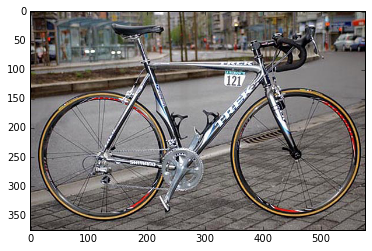

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


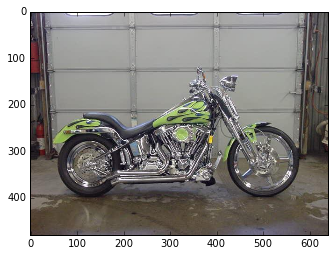

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


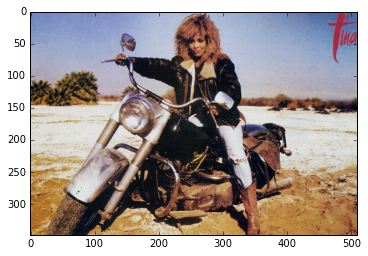

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


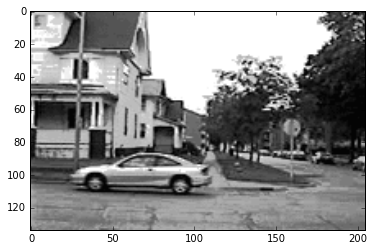

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


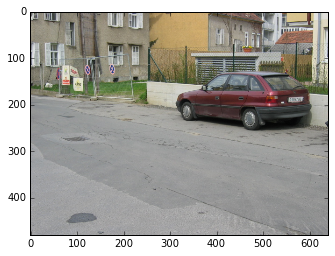

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


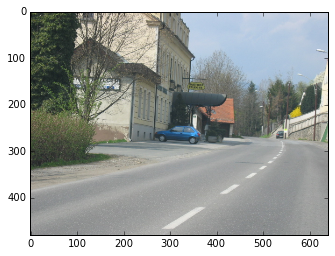

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


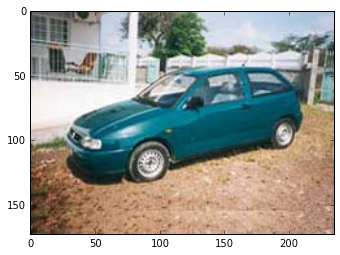

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


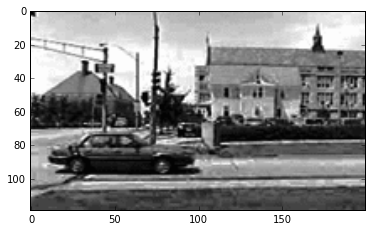

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


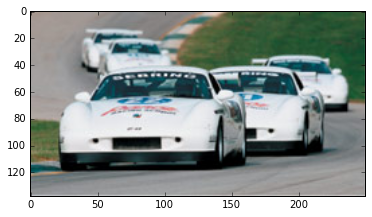

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


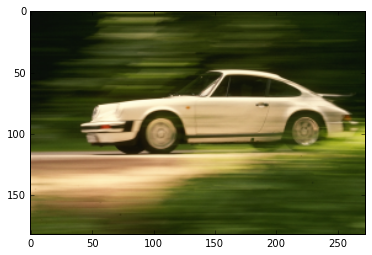

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


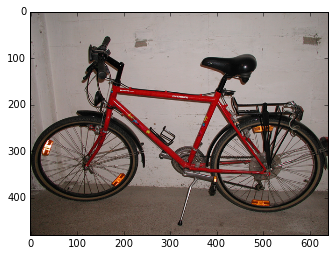

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


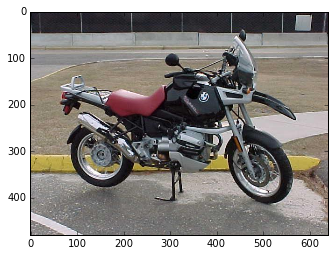

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


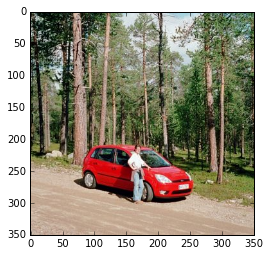

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


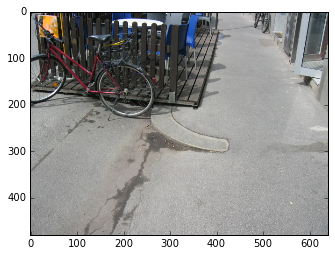

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


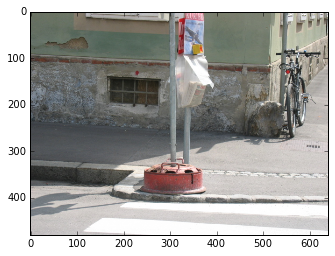

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


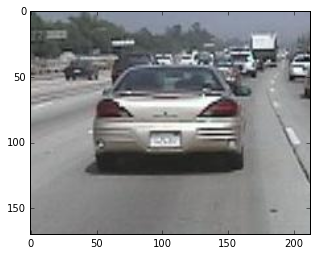

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


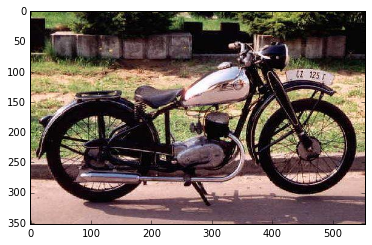

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


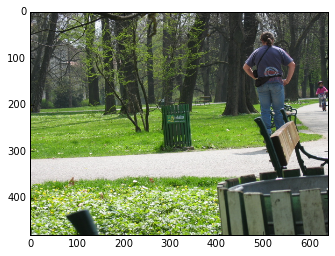

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


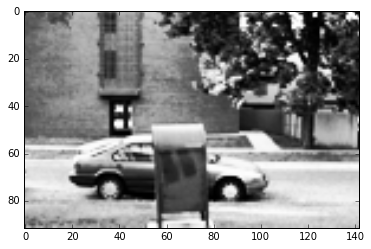

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


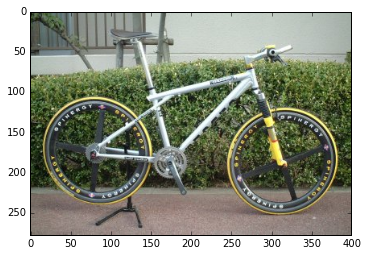

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


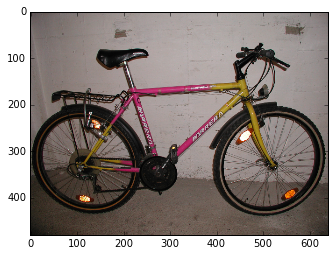

(Pdb) 


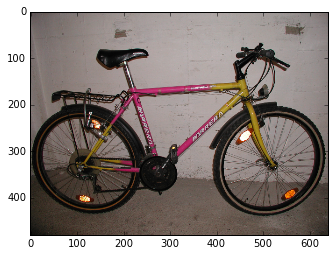

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


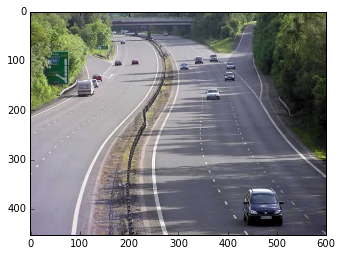

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


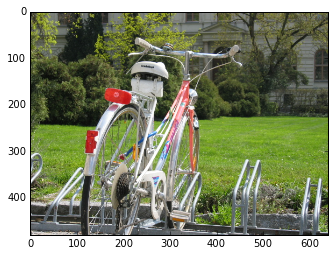

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


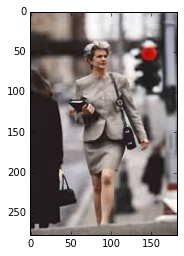

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


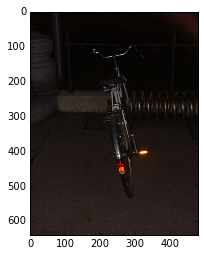

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


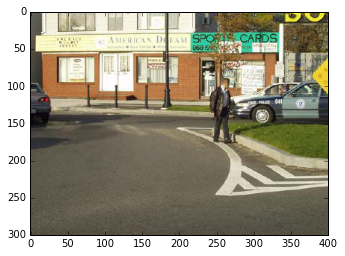

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


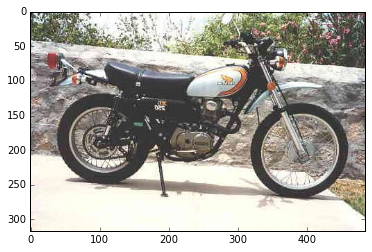

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) 
(Pdb) plt.imshow(im); plt.show()


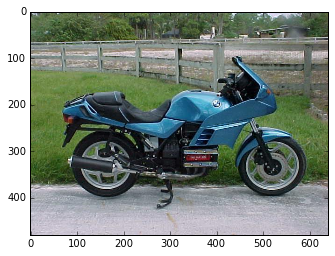

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(263)generate_data()
-> if np.prod(new_im.shape) > 0:
(Pdb) plt.imshow(im); plt.show()


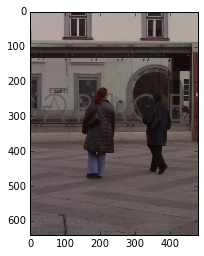

(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(262)generate_data()
-> pdb.set_trace()
(Pdb) plt.imshow(im); plt.show()


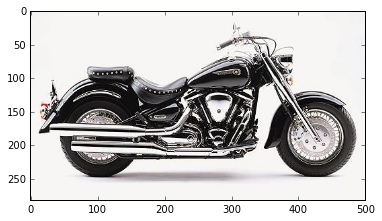

(Pdb) new_box
(52.5553495217,170.532178941) (596.902029508,225.010540812)
(Pdb) plt.imshow(new_im); plt.show()


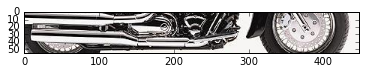

(Pdb) new_box = BoundBox.gen_randombox(iou, obj_box)
*** NameError: name 'BoundBox' is not defined
(Pdb) new_box = BoundingBox.gen_randombox(iou, obj_box)
(Pdb) new_box
(-628.688332623,-2.06939529244) (743.07266262,67.7390994638)
(Pdb) plt.imshow(new_box.subimage(im)); plt.show()


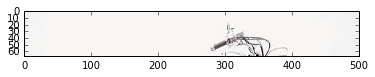

(Pdb) iou
0.21257552446436995
(Pdb) new_box = BoundingBox.gen_randombox(.85, obj_box)
*** KeyboardInterrupt: 
(Pdb) new_box = BoundingBox.gen_randombox(.85, obj_box)
(Pdb) new_box
(48.7897063561,-57.365454041) (472.804699905,242.786231816)
(Pdb) plt.imshow(new_box.subimage(im)); plt.show()


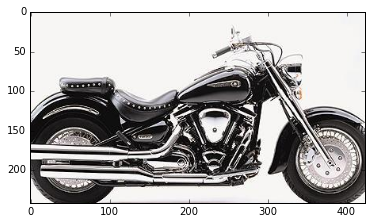

(Pdb) new_box = BoundingBox.gen_randombox(.5, obj_box)
(Pdb) plt.imshow(new_box.subimage(im)); plt.show()


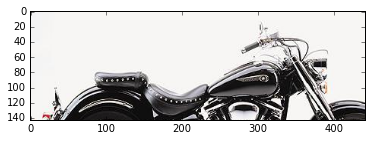

(Pdb) q


BdbQuit: 

In [188]:
accarr = []
gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:50], input_shape, num_classes, num_rios=1, per_batch=50)
for X,y in gen:
    acc = acc_fn(X,y[:,-5:])
    print acc
    accarr.append(acc)
print np.mean(accarr)

In [51]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [130]:
idx = np.arange(X.shape[0])[np.bitwise_not(acc2_fn(X,y[:,-5:]).astype(np.bool))]

In [180]:
N = idx[int(idx.size * np.random.rand())]

In [181]:
im, lab, pred = swap(X[N]), num2label(y[N,-5:].argmax()), pred_fn(X[[N]])[0]

Prediction: bike, Conf: 0.989991, Ground Truth: noobj


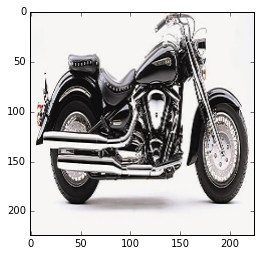

In [182]:
plt.imshow(im)
print('Prediction: %s, Conf: %s, Ground Truth: %s' % (num2label(pred.argmax()), pred.max(), lab))

In [187]:
N

22